# This notebook performs topic modeling on lyrics to that we can investigate questions including : The differences between East Coast and West Coast rap

In [1]:
# common Python imports
import sys
import os
import re
from collections import defaultdict
import pickle
import datetime

In [2]:
# enable inline plotting in our notebook
import seaborn
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [3]:
# these are used for NLP, Data Manipulation, etc
import gensim
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

c:\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load some NLTK data before we get started

In [4]:
%time nltk.download('punkt')
%time nltk.download('stopwords')
%time nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 1.64 s
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Wall time: 2 ms
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Wall time: 24.1 ms


True

# And load a part-of-speech tagging model that was already trained

In [5]:
# helper function to translate POS tags from treebank to wordnet
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

## Note that if for some reason this POS tagger .pickle file will not load, try running 'dos2unix' on it within Cygwin

In [6]:
# set up our lemmatizer in case we enable it
lemma = nltk.wordnet.WordNetLemmatizer()

# and load a POS tagger
# let's also load and test a Brill Part of Speech tagger which was trained on the Penn Treebank:
BRILL_TAGGER_FILE_PATH = 'resources/treebank_brill_aubt.pickle'
brill_tagger = pickle.load(open(BRILL_TAGGER_FILE_PATH, 'rb'))
print(brill_tagger)

# now let's kick the tires on this tagger
test_tag_tokens = 'The cat walked onto an airplane'.split()
print(brill_tagger.tag(test_tag_tokens))

print([lemma.lemmatize(x[0], get_wordnet_pos(x[1])) for x in brill_tagger.tag(test_tag_tokens)])

[('The', 'DT'), ('cat', '-None-'), ('walked', 'VBD'), ('onto', 'IN'), ('an', 'DT'), ('airplane', 'NN')]
['The', 'cat', 'walk', 'onto', 'an', 'airplane']


In [7]:
test_sentence_2 = 'Get me on the court and I\'m trouble Last week fucked around and got a triple double'
print(brill_tagger.tag(test_sentence_2.split()))

[('Get', '-None-'), ('me', 'PRP'), ('on', 'IN'), ('the', 'DT'), ('court', 'NN'), ('and', 'CC'), ("I'm", '-None-'), ('trouble', 'NN'), ('Last', 'JJ'), ('week', 'NN'), ('fucked', 'VBD'), ('around', 'IN'), ('and', 'CC'), ('got', 'VBD'), ('a', 'DT'), ('triple', 'RB'), ('double', 'VB')]


# Load some stopwords -- words which are commonly filtered out since they are common or do not carry much meaning

In [8]:
# load a stopword set we want to use...
stoplist = nltk.corpus.stopwords.words('english')
stop_word_set = set(stoplist)

# variant spellings of stop words
stop_word_set.add('tha')
stop_word_set.add('da')
stop_word_set.add('ain\t')
stop_word_set.add('aint')
stop_word_set.add('gonna')
stop_word_set.add('\'bout')
stop_word_set.add('\'til')
stop_word_set.add('ainâ€™t')
stop_word_set.add('iâ€™m')
stop_word_set.add('i\'mma')
stop_word_set.add('thee')
stop_word_set.add('whatz')
stop_word_set.add('along')
stop_word_set.add('dont')
stop_word_set.add('beyond')

# we'll remove a few more from our dataset
if False:
    stop_word_set.add('get')
    stop_word_set.add('got')
    stop_word_set.add('nigga')
    stop_word_set.add('niggas')
    stop_word_set.add('bitch')
    stop_word_set.add('fuck')
    stop_word_set.add('ain\t')
    stop_word_set.add('aint')

print(stop_word_set)

{'the', 'been', 'with', 'mustn', 'they', 'hadn', "you've", 'how', "that'll", 'o', "'bout", 'as', 'whatz', 'against', 'same', "haven't", 'until', 'so', 'only', 'mightn', 'again', 'couldn', 'yourselves', 'why', "you'd", 'itself', 'who', 'over', 'himself', 'd', 'and', 'from', 'then', 'm', 've', 'too', 'what', 'i', 'doing', 'whom', 'dont', "shan't", 'ours', 'in', 'into', 'about', 'are', "you'll", "you're", 's', 'should', 'beyond', 'because', "shouldn't", 'any', 'under', 'than', 'off', 'hasn', "won't", "wouldn't", "isn't", 'down', 'him', 're', 'their', "weren't", "needn't", 'weren', 'ain', "didn't", 'didn', 'of', 'hers', 'has', 'da', 'not', 'an', 'yourself', 'here', 'before', 'there', "wasn't", 'or', 'your', 'nor', "aren't", 'ainâ€™t', 'y', "she's", 'ma', 'shouldn', 'wouldn', 'iâ€™m', 'that', 'each', "couldn't", 'where', 'but', 'other', 'doesn', 'myself', "it's", 'most', 'isn', 'ourselves', "hasn't", 'such', 'tha', 'them', 'this', 'on', "should've", 'by', "'til", "mustn't", 'once', 'being',

# Loading the dataset
## This dataset comes from the Kaggle website at this URL: https://www.kaggle.com/artimous/every-song-you-have-heard-almost

In [9]:
%%time

print('Loading dataframes from CSV.  This might take some time...')

# NOTE : Without setting the engine here, we might hit the exception : "C error: EOF inside string ..."

# This dataset is comprised of two separate files possibly for size and download limitations
# so we'll put them together in a moment...
lyrics_1_df = pd.read_csv('c:/datasets/lyrics/lyrics1.csv',
                       engine = 'python')
lyrics_2_df = pd.read_csv('c:/datasets/lyrics/lyrics2.csv',
                       engine = 'python')
# now we can put them together into a single frame
lyrics_df = pd.concat([lyrics_1_df, lyrics_2_df])

print('Length of Set #1 : {}'.format(len(lyrics_1_df)))
print('Length of Set #2 : {}'.format(len(lyrics_2_df)))
print('Length of Both Set combined : {}'.format(len(lyrics_df)))

Loading dataframes from CSV.  This might take some time...
Length of Set #1 : 250000
Length of Set #2 : 266174
Length of Both Set combined : 516174
Wall time: 14.6 s


In [10]:
#replace carriage returns with periods to see if we can split lyrics as if they are sentences
lyrics_df = lyrics_df.replace({'\n': ' . '}, regex=True)

In [11]:
lyrics_df.head(10)

,Band,Lyrics,Song
0,Elijah Blake,"No, no . I ain't ever trapped out the bando . ...",Everyday
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die
2,Elijah Blake,She don't live on planet Earth no more . She f...,The Otherside
3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low ...",Pinot
4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds
5,Elijah Blake,I just want to ready your mind . 'Cause I'll s...,Uno
6,Elijah Harris,To believe . Or not to believe . That is the q...,Girlfriend (Main)
7,Elijah Levi,"No one here can love or understand me . Oh, wh...",Bye Bye Blackbird
8,Elijah Levi,"Lullaby of Birdland, that's what I . Always h...",Lullaby of Birdland
9,Elijah Levi,I hate to see that evening sun go down . I hat...,St. Louis Blues


# Before we start do do any text analysis, let's figure out the Hip-Hop artists we have

In [12]:
# NOTE : Could not find the following in this set : 
# EAST COAST : Nas
# WEST COAST : Warren G, Tha Dogg Pound
east_coast_artists = ['The Notorious B.I.G.', 'Diddy', 'Wu-Tang Clan', 'Craig Mack', 'Tim Dog', 
                      'Queen Latifah', 'LL Cool J', 'Da Brat', 'Missy Elliott', 'MC Lyte', 'De La Soul', 'Busta Rhymes', 'Mase', 'Q-Tip']
west_coast_artists = ['N.W.A', 'Dr. Dre', '2Pac', 'Eazy-E', 'Ice Cube', 'Snoop Dogg', 'Nate Dogg', 'Daz Dillinger', 'Coolio']

male_artists = ['N.W.A', 'Dr. Dre', '2Pac', 'Eazy-E', 'Ice Cube', 'Snoop Dogg', 'Nate Dogg', 'Daz Dillinger', 
                    'The Notorious B.I.G.', 'Diddy', 'Wu-Tang Clan', 'Craig Mack', 'Tim Dog', 
                      'LL Cool J', 'De La Soul', 'Busta Rhymes', 'Mase', 'Q-Tip', 'Coolio']
female_artists = ['Queen Latifah', 'Da Brat', 'Missy Elliott', 'MC Lyte']

In [13]:
artist_check_df = lyrics_df[lyrics_df['Band'].str.contains("Tip")].groupby(['Band']).size()
print(artist_check_df)

Band
Chicory Tip                      6
George Tipton                    1
Glenn Tipton                    13
Hollow Tip                       3
Julie Tippetts                   6
La Tipica Orquestra de Tango     1
Q-Tip                           29
Q-Tips                           3
dtype: int64


In [14]:
artist_song_check_df = lyrics_df[lyrics_df['Band'] == 'Craig Mack']['Song']
print(artist_song_check_df)

84884           Flava in Ya Ear
84885         Funk Wit da Style
84886                  Get Down
84887             Judgement Day
84888                  Mainline
84889    Making Moves With Puff
84890    Project: Funk da World
84891                  Real Raw
84892            When God Comes
Name: Song, dtype: object


In [15]:
coast_conditions = [
    (lyrics_df['Band'].isin(east_coast_artists)),
    (lyrics_df['Band'].isin(west_coast_artists))]
coast_choices = ['East', 'West']
lyrics_df['Coast'] = np.select(coast_conditions, coast_choices, default='')

In [16]:
gender_conditions = [
    (lyrics_df['Band'].isin(male_artists)),
    (lyrics_df['Band'].isin(female_artists))]
gender_choices = ['Male', 'Female']
lyrics_df['Gender'] = np.select(gender_conditions, gender_choices, default='')

In [17]:
rap_df = lyrics_df[lyrics_df['Coast'].str.len() > 0]

In [18]:
print(rap_df.groupby(['Band', 'Coast', 'Gender']).size())

Band                  Coast  Gender
2Pac                  West   Male      252
Busta Rhymes          East   Male      159
Coolio                West   Male       66
Craig Mack            East   Male        9
Da Brat               East   Female     46
Daz Dillinger         West   Male       22
De La Soul            East   Male      132
Diddy                 East   Male      104
Dr. Dre               West   Male       80
Eazy-E                West   Male       24
Ice Cube              West   Male      178
LL Cool J             East   Male      167
MC Lyte               East   Female     59
Mase                  East   Male       53
Missy Elliott         East   Female    127
N.W.A                 West   Male       22
Nate Dogg             West   Male       40
Q-Tip                 East   Male       29
Queen Latifah         East   Female     50
Snoop Dogg            West   Male      344
The Notorious B.I.G.  East   Male       90
Tim Dog               East   Male        7
Wu-Tang Clan      

In [19]:
print(rap_df.groupby(['Coast']).size())

Coast
East    1157
West    1028
dtype: int64


In [20]:
print(rap_df.groupby(['Gender']).size())

Gender
Female     282
Male      1903
dtype: int64


In [21]:
# let's write this to a file
rap_artist_filename = 'rap_artists.csv'
rap_df.to_csv(rap_artist_filename)
print('Wrote Rap artist file to CSV : {}'.format(rap_artist_filename))

Wrote Rap artist file to CSV : rap_artists.csv


In [22]:
text_list = rap_df['Lyrics'].tolist()
index_list = rap_df.index.values

# Now before we start working with the text, let's handle some of it's formatted.  Since many of the lyrics are back and forth between artists and sometimes parts of the songs are marked up, let's handle this by removing them so that they do not dominate our vocabulary.  Otherwise, we see the words 'snoop' and 'dogg' all over the topic model because he is featured in so many songs even if he is not the artist.  We'll do this with regular expressions:
* Replace [ARTIST NAME] with blanks
* Replace [chorus] with blanks
* etc

In [23]:
test_clean_string_1 = '[Bigg Snoop Dogg] Who let them Eastside ridaz out? [Dogg] [ Dre ]'
test_clean_string_2 = 'I am the verse [chorus] I am the part that repeats'

print('About to clean strings...')

# match brackets with up to 30 characters in between
bracket_pattern = re.compile('\[.{1,30}\]')
print(bracket_pattern.sub(' . ', test_clean_string_1))
print(bracket_pattern.sub(' . ', test_clean_string_2))

About to clean strings...
 .  Who let them Eastside ridaz out?  . 
I am the verse  .  I am the part that repeats


In [24]:
# process all of sentences for this formatting
characters_removed_list = []
for i in range(len(text_list)):
    original_text = text_list[i]
    text_length_before = len(original_text)
    clean_format_text = bracket_pattern.sub(' . ', original_text)
    text_length_after = len(clean_format_text)
    characters_removed = text_length_before - text_length_after
    characters_removed_list.append(characters_removed)
    text_list[i] = clean_format_text
    
print('Text cleaned of formatting')
print('Average characters removed per document : {}'.format(np.mean(np.array(characters_removed_list))))

#print(text_list[10])

Text cleaned of formatting
Average characters removed per document : 16.184439359267735


In [25]:
%%time

tokenized_texts = []
token_count_list = []
unique_token_set = set()
for i, text in enumerate(text_list):
    if i % 1000 == 0:
        print('Tokenization process : [{0}/{1}]'.format(i, len(text_list)))
        
    # get the index into the original text
    index = text_list[i]
        
    # there are lots and lots of rows which have no lyrics at all, so let's skip them
    if not isinstance(text, str):
        #print('Skipping column type : {0} at index {1}'.format(type(text), index))  
        continue
        
    # this is a better way to tokenize, but for the interest of time, we will tokenize with
    # whitespace using python's split() function
    tokens = nltk.word_tokenize(text.lower())
    #tokens = text.lower().split()
    tokenized_texts.append(tokens)
    token_count_list.append(len(tokens))
    unique_token_set |= set(tokens)
    
print('Total size of tokenized list : {}'.format(len(tokenized_texts)))
print('Total size of unique tokens : {}'.format(len(unique_token_set)))
print('DONE reading, tokenizing and counting')

Tokenization process : [0/2185]
Tokenization process : [1000/2185]
Tokenization process : [2000/2185]
Total size of tokenized list : 2185
Total size of unique tokens : 33120
DONE reading, tokenizing and counting
Wall time: 18.7 s


# Before we go much further, let's set up a dataframe to gather statistics on our vocabulary including term frequency, term rarity using Inverse Document Frequency (IDF) and others

In [26]:
def get_term_stats_df(tokenized_texts, stop_word_set, enable_phrase_stats = False):
    # TODO : Is this really the best way to calculate TF-IDF?  By document?  Shouldn't this be by vocabulary?
    print('Building Dictionary...')
    dictionary = gensim.corpora.Dictionary(tokenized_texts)
    
    print('Setting up Bag-of-Words for [{0}] documents...'.format(len(tokenized_texts)))
    unfiltered_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # now before we start using this, let's look at some term weighting with TF-IDF to see if there are some terms we can easily ignore
    # (e.g. patient, patient, cell, cells, etc) which occur very frequently across nearly all documents

    tfidf = gensim.models.TfidfModel(unfiltered_corpus, id2word=dictionary)
    
    print('TF-IDF model built and now setting up dataframe...')
    global_idf_map = {}
    term_dicts = []
    for id in tfidf.id2word.keys():
        word = tfidf.id2word[id]
        global_tf = tfidf.dfs[id]
        global_idf = tfidf.idfs[id]
        global_tfidf = global_tf * float(global_idf)
        global_idf_map[id] = global_tfidf
        
        stopword = word in stop_word_set
        
        any_alpha = any(c.isalpha() for c in word)
        all_alpha = word.isalpha()
        alpha_num = word.isalnum()
        phrase = '_' in word
        
        phrase_stopword_edge = False
        phrase_noalpha_edge = False
        phrase_disallowed_start = False
        if enable_phrase_stats and phrase:
            phrase_stopword_edge = phrase_has_stopword_edge(word, stop_word_set)
            phrase_noalpha_edge = phrase_has_no_alpha_edge(word)
            phrase_disallowed_start =  phrase_has_disallowed_start(word)

        term_dict = {'@Token' : word, 'Global TF' : global_tf, 
                     'Global TF-IDF' : global_tfidf, 'Global IDF' : global_idf,
                    'Stopword' : stopword, 'Phrase' : phrase,
                    'Any Alphabetic' : any_alpha, 'All Alphabetic' : all_alpha, 'All Alphanumeric' : alpha_num,
                    #'Phrase Stopword Edge' : phrase_stopword_edge, 'Phrase No Alpha Edge' : phrase_noalpha_edge,
                    #'Phrase Disallowed Start' : phrase_disallowed_start
                    }
        term_dicts.append(term_dict)

    term_stats_df = pd.DataFrame(term_dicts)
    term_stats_df = term_stats_df.sort_values('Global TF', ascending = False)
    return term_stats_df

In [27]:
%%time

print('Prepping stats for completely unfiltered vocabulary...')
unfiltered_term_stats_df = get_term_stats_df(tokenized_texts, stop_word_set)

display(unfiltered_term_stats_df.head(5))

Prepping stats for completely unfiltered vocabulary...
Building Dictionary...
Setting up Bag-of-Words for [2185] documents...
TF-IDF model built and now setting up dataframe...


,@Token,All Alphabetic,All Alphanumeric,Any Alphabetic,Global IDF,Global TF,Global TF-IDF,Phrase,Stopword
9,.,False,False,False,0.000660,2184,1.442365,False,False
237,the,True,True,True,0.012600,2166,27.291680,False,True
124,i,True,True,True,0.019945,2155,42.982359,False,True
240,to,True,True,True,0.021955,2152,47.247594,False,True
28,and,True,True,True,0.028001,2143,60.007064,False,True


Wall time: 2.1 s


In [28]:
unfiltered_term_stats_filename = 'unfiltered_term_stats_{0}.csv'.format(datetime.datetime.now().strftime("%m_%d"))
print('Writing Term Stats CSV to : {}'.format(unfiltered_term_stats_filename))

unfiltered_term_stats_df.to_csv(unfiltered_term_stats_filename)

print('DONE Writing Term Stats CSV to : {}'.format(unfiltered_term_stats_filename))

Writing Term Stats CSV to : unfiltered_term_stats_07_04.csv
DONE Writing Term Stats CSV to : unfiltered_term_stats_07_04.csv


In [29]:
# Let's plot the distribution of terms as well
#global_idf_series = pd.Series(unfiltered_term_stats_df['Global IDF'], name='Global IDF')
        
# let's look at the distribution of TF-IDF values
#seaborn.distplot(global_idf_series);

# Now we'll process and clean the texts before we train a topic model...

In [30]:
class Token:
    def __init__(self, token, pos):
        self.token = token
        self.pos = pos
        
    def __repr__(self):
        return '{0}/{1}'.format(self.token, self.pos)

In [31]:
CULL_ARTIST_NAMES = True

In [32]:
MIN_TERM_FREQUENCY = 5
MIN_TOKEN_LENGTH = 4
CULL_STOP_WORDS = True
CULL_BY_MIN_FREQUENCY = True
CULL_NON_ALPHA = True
CULL_TOKENS_WITH_NO_ALPHA = True
CULL_SHORT_TOKENS = True
CULL_SLANG_IN_VERBS = True
CULL_PHRASES_WITH_STOPWORD_EDGE = False
CULL_PHRASE_NO_ALPHA_EDGE = False
CULL_PHRASE_DISALLOWED_START = False
CULL_NON_NOUNS = True
FILTER_DICTIONARY_BY_GLOBAL_IDF = True
MIN_GLOBAL_IDF_VALUE = 4.0

In [33]:
# but for now we'll use the original text verbatim
filtered_tokenized_texts = tokenized_texts

print(filtered_tokenized_texts[0][:50])

['his', 'realm', 'is', 'a', 'new', 'horizon', 'of', 'cuts', '.', 'they', 'expand', 'from', 'his', 'hand', 'as', 'he', 'conducts', '.', 'aim', 'a', 'lot', 'of', 'cool', 'projects', 'not', 'photography', '.', 'cut-creator', ',', 'philly-phil', "'s", 'biography', '.', '.', 'the', 'lyrical', 'virtual', 'also', 'makes', 'his', 'return', '.', 'all', 'adversaries', 'should', 'be', 'concerned', '.', 'll', 'cool']


In [34]:
if CULL_ARTIST_NAMES:
    all_artist_name_set = set(rap_df['Band'].tolist())
    print('Adding [{}] artist names to STOP WORD LIST...'.format(len(all_artist_name_set)))
    for artist_name in all_artist_name_set:
        artist_tokens = artist_name.split()
        for artist_token in artist_tokens:
            stop_word_set.add(artist_token.lower())
            
            
    # let's also add some other variants of artist names that may be different from the names in this set
    stop_word_set.add('pac')
    stop_word_set.add('2-pac')
    stop_word_set.add('2pac')
    stop_word_set.add('biggie')
    stop_word_set.add('smalls')
    stop_word_set.add('smallz')
    stop_word_set.add('dogg')
    stop_word_set.add('doggy')
    stop_word_set.add('bone')
    stop_word_set.add('tang')
    
    print('Total updates stopword set size : {}'.format(len(stop_word_set)))

Adding [23] artist names to STOP WORD LIST...
Total updates stopword set size : 240


In [35]:
# convert everything into this class even if we do not do POS tagging
if CULL_NON_NOUNS:
    print('Preparing Token and POS information for later culling...')
    for i in range(len(filtered_tokenized_texts)):
        document_tokens = filtered_tokenized_texts[i]
        token_objects = [Token(pos[0], pos[1]) for pos in brill_tagger.tag(document_tokens)]
        filtered_tokenized_texts[i] = token_objects
        
        #print(document_tokens)
        #break
    
    print('DONE with part of speech tagging')
    
else:
    print('Preparing Token information even without culling later')
    for i in range(len(filtered_tokenized_texts)):
        document_tokens = filtered_tokenized_texts[i]
        token_objects = [Token(token, '') for token in document_tokens if len(token) > 0]
        # store this back in 
        filtered_tokenized_texts[i] = token_objects
    
#print(filtered_tokenized_texts[:10])
print(filtered_tokenized_texts[0][:50])

Preparing Token and POS information for later culling...
DONE with part of speech tagging
[his/PRP$, realm/-None-, is/VBZ, a/DT, new/JJ, horizon/NNP, of/IN, cuts/NNS, ./., they/PRP, expand/VB, from/IN, his/PRP$, hand/NN, as/IN, he/PRP, conducts/NNS, ./., aim/VB, a/DT, lot/NN, of/IN, cool/JJ, projects/NNS, not/RB, photography/NN, ./., cut-creator/NN, ,/,, philly-phil/-None-, 's/POS, biography/NN, ./., ./., the/DT, lyrical/JJ, virtual/JJ, also/RB, makes/VBZ, his/PRP$, return/NN, ./., all/DT, adversaries/NNS, should/MD, be/VB, concerned/VBN, ./., ll/-None-, cool/JJ]


In [36]:
%%time

# Finally, prepare to remove words below a frequency threshold
frequency = defaultdict(int)
for text in filtered_tokenized_texts:
    for token in text:
        frequency[token.token] += 1

if CULL_BY_MIN_FREQUENCY:
    print('Culling by min frequency...')
    # CULL by frequency
    filtered_tokenized_texts = [[token for token in text if frequency[token.token] > MIN_TERM_FREQUENCY]
             for text in filtered_tokenized_texts]
        
if CULL_STOP_WORDS:
    print('Culling stopwords...')
    # then CULL by alpha
    filtered_tokenized_texts = [[token for token in text if token.token not in stop_word_set]
             for text in filtered_tokenized_texts]
    
if CULL_NON_NOUNS:
    # keep this for any noun or any phrase ('_') since phrases may not be properly labeled for part of speech
    filtered_tokenized_texts = [[token for token in text if ('_' in token.token or get_wordnet_pos(token.pos) == nltk.corpus.wordnet.NOUN)]
             for text in filtered_tokenized_texts]
    
if CULL_PHRASES_WITH_STOPWORD_EDGE:
    print('Culling phrases with a stopword on their EDGE')
    filtered_tokenized_texts = [[token for token in text if not phrase_has_stopword_edge(token.token, stop_word_set)]
             for text in filtered_tokenized_texts]
    
if CULL_PHRASE_NO_ALPHA_EDGE:
    print('Culling phrases with a NO ALPHA term on their EDGE')
    filtered_tokenized_texts = [[token for token in text if not phrase_has_no_alpha_edge(token.token)]
             for text in filtered_tokenized_texts]
    
if CULL_PHRASE_DISALLOWED_START:
    print('Culling phrases starting with a DISALLOWED term (e.g. "p", "n")')
    filtered_tokenized_texts = [[token for token in text if not phrase_has_disallowed_start(token.token)]
             for text in filtered_tokenized_texts]
    
# NOTE that this culling only culls tokens which have NO alpha tokens at all
# which is very different that the processing below
# this will enable this:
# 'TP53' whereas the method below would cull it
if CULL_TOKENS_WITH_NO_ALPHA:
    filtered_tokenized_texts = [[token for token in text if any(c.isalpha() for c in token.token)]
             for text in filtered_tokenized_texts]

if CULL_NON_ALPHA:
    print('Culling all non-alpha tokens...')
    # then CULL by alpha
    filtered_tokenized_texts = [[token for token in text if token.token.isalpha()]
             for text in filtered_tokenized_texts]
    
if CULL_SHORT_TOKENS:
    filtered_tokenized_texts = [[token for token in text if len(token.token) >= MIN_TOKEN_LENGTH]
             for text in filtered_tokenized_texts]
    
if CULL_SLANG_IN_VERBS:
    print('Culling terms ending with \'in...')
    filtered_tokenized_texts = [[token for token in text if not token.token.endswith('in')]
             for text in filtered_tokenized_texts]
    
# finally convert back from the object into simple token strings
filtered_tokenized_texts = [[token.token for token in text] for text in filtered_tokenized_texts]

DEMO_WORDS_TO_PRINT = 50

print('Demo document tokens:')
print(filtered_tokenized_texts[0][:DEMO_WORDS_TO_PRINT])

Culling by min frequency...
Culling stopwords...
Culling all non-alpha tokens...
Culling terms ending with 'in...
Demo document tokens:
['cuts', 'hand', 'projects', 'return', 'adversaries', 'friend', 'till', 'missions', 'collision', 'like', 'head', 'decision', 'eggs', 'lyrics', 'subject', 'matter', 'sucker', 'scatter', 'techniques', 'absorb', 'cuts', 'name', 'boys', 'could', 'brains', 'change', 'tree', 'yeah', 'scenario', 'stereo', 'zero', 'rappers', 'evade', 'invade', 'compliment', 'groups', 'talent', 'mine', 'harmony', 'cuts', 'rhyme', 'deaf', 'bass', 'every', 'sucker', 'place', 'phrase', 'record', 'scratch', 'except']
Wall time: 2.72 s


# Set up our initial dictionary

In [37]:
dictionary = gensim.corpora.Dictionary(filtered_tokenized_texts)
print('Total dictionary size : [{}]'.format(len(dictionary.keys())))

Total dictionary size : [4342]


# But before we go on, let's see if we should filter our vocabulary of very common terms (IDF)

In [38]:
def filter_dictionary_by_global_idf(corpus, tokenized_texts, tfidf_model, dictionary, min_global_idf_value, 
                                    print_low_value_words = True):
    low_value_words = set()
    low_value_ids = set()
    for id in tfidf.id2word.keys():
        word = tfidf.id2word[id]
        global_tf = tfidf.dfs[id]
        global_idf = tfidf.idfs[id]
        if global_idf < min_global_idf_value:
            low_value_words.add(word)
            low_value_ids.add(id)
            
    print('Total number of words removed : [{}]'.format(len(low_value_words)))

    if print_low_value_words:
        print('Here are all the words we will remove from our dictionary by global IDF')
        print(sorted(list(low_value_words)))
        
        low_value_word_percent = len(low_value_words) / float(len(dictionary))

        print('Total low value words : {0}'.format(len(low_value_words)))
        print('Total low value Total Vocab percent : {0}'.format(low_value_word_percent))
        
    # now we can filter
    dictionary.filter_tokens(bad_ids=low_value_ids)

In [39]:
# NOTE : This class was taken from an example here:
# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb

class Corpus(gensim.corpora.textcorpus.TextCorpus):

    def get_texts(self):
        # let's also make sure that all empty documents (no tokens) are not included 
        # NOTE : The DIM model (model = 'fixed') breaks if there are any documents with no tokens
        # also, apparently the logic for checking this is any(not text), so let's try that
        #print('Calling a version of get_texts() that should not allow empty/None lists...')
        return [x for x in self.input]

    def __len__(self):
        return len(self.input)

In [40]:
corpus = Corpus(filtered_tokenized_texts)

# this is a corpus which has not yet been pruned so we can do meaningful TF-IDF calculations with it
# NOTE that we call "token.token" since it is of class token and we want the string for the actual token
unfiltered_corpus = [dictionary.doc2bow([token.token for token in tokens]) for tokens in tokenized_texts]

tfidf = gensim.models.TfidfModel(unfiltered_corpus, id2word=dictionary)

print('Corpus length : {}'.format(len(corpus)))

if FILTER_DICTIONARY_BY_GLOBAL_IDF:
    print('Total dictionary size BEFORE TF-IDF filtering : [{}]'.format(len(dictionary.keys())))
    
    filter_dictionary_by_global_idf(unfiltered_corpus, filtered_tokenized_texts, tfidf, dictionary, MIN_GLOBAL_IDF_VALUE)
    print(dictionary)
    print(corpus.dictionary)
    # re-point the new dictionary for the corpus
    corpus.dictionary = dictionary
    
    print('Total dictionary size AFTER TF-IDF filtering : [{}]'.format(len(corpus.dictionary.keys())))

Corpus length : 2185
Total dictionary size BEFORE TF-IDF filtering : [4342]
Total number of words removed : [257]
Here are all the words we will remove from our dictionary by global IDF
['another', 'around', 'away', 'baby', 'back', 'ball', 'bang', 'beach', 'behind', 'bitch', 'bitches', 'black', 'blast', 'block', 'blood', 'blow', 'body', 'bomb', 'boss', 'bout', 'boys', 'brothers', 'bust', 'call', 'care', 'case', 'cash', 'catch', 'cause', 'change', 'chest', 'chill', 'city', 'close', 'clothes', 'club', 'cold', 'control', 'cops', 'corner', 'could', 'crack', 'crazy', 'daddy', 'dance', 'days', 'deal', 'death', 'dick', 'dollar', 'door', 'dope', 'dough', 'dream', 'drink', 'drop', 'enough', 'every', 'everybody', 'everything', 'eyes', 'face', 'fact', 'fall', 'family', 'fast', 'feet', 'fight', 'fire', 'five', 'flip', 'floor', 'flow', 'fool', 'fools', 'forever', 'four', 'friend', 'friends', 'front', 'fuck', 'funk', 'game', 'gang', 'gangsta', 'ghetto', 'girl', 'girls', 'glock', 'gold', 'grab', 'gri

In [41]:
%%time 

NUM_TOPICS = 6
NUM_WORKERS = 6
VANILLA_LDA_PASSES = 30

TRAIN_MULTICORE_MODEL = False

# train model
lda = None
if TRAIN_MULTICORE_MODEL:
    print('Training multicore model...')
    lda = gensim.models.LdaMulticore(corpus, 
                                     id2word = dictionary, 
                                     num_topics = NUM_TOPICS, 
                                     workers = NUM_WORKERS, 
                                     passes = VANILLA_LDA_PASSES)
else:
    print('Training single-core model...')
    lda = gensim.models.ldamodel.LdaModel(corpus, 
                                     id2word = dictionary, 
                                     num_topics = NUM_TOPICS,
                                         passes = VANILLA_LDA_PASSES)

Training single-core model...
Wall time: 29.7 s


In [42]:
lda.print_topics(-1)

[(0,
  '0.043*"enemies" + 0.016*"swear" + 0.016*"outlaw" + 0.010*"soldiers" + 0.010*"slang" + 0.009*"jail" + 0.008*"holla" + 0.008*"hail" + 0.008*"makaveli" + 0.008*"thugs"'),
 (1,
  '0.006*"nation" + 0.006*"hustle" + 0.005*"season" + 0.005*"children" + 0.005*"cappucino" + 0.004*"self" + 0.004*"holla" + 0.003*"haters" + 0.003*"hook" + 0.003*"battle"'),
 (2,
  '0.011*"brooklyn" + 0.008*"chick" + 0.007*"exchange" + 0.007*"chorus" + 0.007*"verse" + 0.006*"lady" + 0.006*"cats" + 0.006*"funky" + 0.005*"ridah" + 0.005*"lick"'),
 (3,
  '0.014*"thugs" + 0.011*"hide" + 0.010*"cards" + 0.010*"homeboys" + 0.009*"toss" + 0.009*"pray" + 0.009*"feelins" + 0.008*"dear" + 0.008*"outlaw" + 0.008*"today"'),
 (4,
  '0.018*"harlem" + 0.016*"mansion" + 0.011*"bail" + 0.011*"california" + 0.010*"cali" + 0.008*"smart" + 0.008*"lane" + 0.008*"dreams" + 0.006*"mutha" + 0.006*"dear"'),
 (5,
  '0.014*"hennessy" + 0.008*"bottle" + 0.008*"shorty" + 0.008*"model" + 0.007*"role" + 0.007*"boom" + 0.006*"playa" + 0.00

# Now that we have a model, let's store the topic inferences back into our dataframe...

In [43]:
for i, index in enumerate(index_list):
    if i % 1000 == 0:
        print('Topic assignment progress : [{0}/{1}]'.format(i, len(index_list)))
        
    doc_bow = corpus.dictionary.doc2bow(filtered_tokenized_texts[i])
       
    document_topic_sparse_list = [0.0] * lda.num_topics
    document_topics = lda.get_document_topics(doc_bow)
    
    # find the topics actually predicted for this document and store them into the array
    for document_topic in document_topics:
        topic_idx = document_topic[0]
        topic_prob = document_topic[1]
        document_topic_sparse_list[topic_idx] = topic_prob
    
    # now we can store these into a dataframe
    for topic_idx, topic_prob in enumerate(document_topic_sparse_list):
        topic_key = 'Topic_{0}'.format(format(topic_idx, '02d'))
        #print(topic_key)
        rap_df = rap_df.set_value(index, topic_key, topic_prob)

Topic assignment progress : [0/2185]


c:\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Topic assignment progress : [1000/2185]
Topic assignment progress : [2000/2185]


In [48]:
display(rap_df.head())

,Band,Lyrics,Song,Coast,Gender,Topic_00,Topic_01,Topic_02,Topic_03,Topic_04,Topic_05
4122,LL Cool J,His realm is a new horizon of cuts . They expa...,Dangerous,East,Male,0.072571,0.360146,0.425595,0.000000,0.000000,0.134692
4123,LL Cool J,"Yo Yvette, there's a lot of rumors goin' aroun...",Dear Yvette,East,Male,0.000000,0.123367,0.120467,0.000000,0.687568,0.065391
4124,LL Cool J,"I seen this girl, walking down the block . I s...",I Can Give You More,East,Male,0.068451,0.284912,0.211001,0.227387,0.055883,0.152367
4125,LL Cool J,"Look girl, I'm not gonna sing . 'Cause I just ...",I Want You,East,Male,0.000000,0.457686,0.100946,0.231581,0.000000,0.205295
4126,LL Cool J,"Yo man, I got this def Rolex watch, man . A hu...",That's a Lie,East,Male,0.018893,0.538924,0.238299,0.154185,0.047479,0.000000


# Now that we have a topic model, let's do some comparison by training ONE MODEL for all data and then we  will stratify by various attributes (i.e. East/West coast) to see how the topics vary with the same model

In [62]:
def visualize_average_topic_by_column(df, col_name, lda_model, top_n_terms = 10):
    unique_col_values = df[col_name].unique()

    column_topic_dicts = []
    topic_name_set = set()
    for unique_col_value in unique_col_values:
        #print('Preparing topic values for column [{0} == {1}]'.format(col_name, unique_col_value))
        
        column_topic_dict = {}
        column_topic_dict[col_name] = unique_col_value
        
        # let's loop through topics and get average values
        for topic_idx in range(lda_model.num_topics):
            #print('Preparing values for Topic : {}'.format(topic_idx))
            topic_key = 'Topic_{0}'.format(format(topic_idx, '02d'))
            topic_probs = df[df[col_name] == unique_col_value][topic_key]
            avg_topic_probs = np.mean(topic_probs)
            
            topic_name_set.add(topic_key)
            
            column_topic_dict[topic_key] = avg_topic_probs
            
        column_topic_dicts.append(column_topic_dict)
        
    # let's set up topic labels for the legend
    topic_labels = []
    for topic_idx in range(lda_model.num_topics):
        topic_key = 'Topic_{0}'.format(format(topic_idx, '02d'))
        topic_term_tuples = lda_model.get_topic_terms(topic_idx, topn = top_n_terms)
        topic_terms = [lda_model.id2word[x[0]] for x in topic_term_tuples]
        topic_terms_str = ', '.join(topic_terms)
        topic_label = '{0} : {1}'.format(topic_key, topic_terms_str)
        topic_labels.append(topic_label)
        
    column_topic_df = pd.DataFrame(column_topic_dicts)
    #display(column_topic_df)
    
    ax = column_topic_df.plot.bar(x = col_name, stacked = True)
    
    # Shrink current axis's height by a percentage on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    leg = plt.legend(topic_labels, loc='upper center', bbox_to_anchor=(0.5, -0.3),
              fancybox=True, shadow=True, ncol=1)

    fig = plt.gcf()
    fig.set_size_inches(10.5, 4.5)
    
    plt.show()

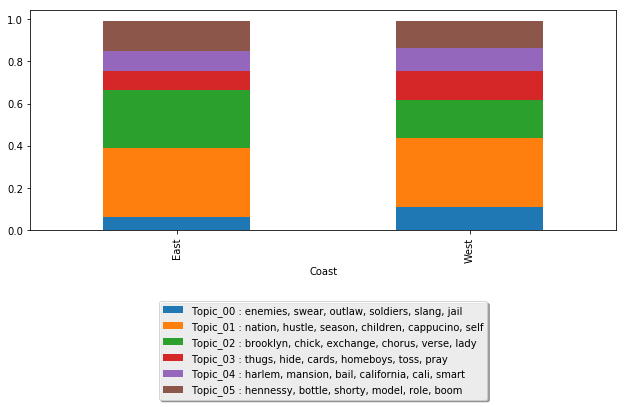

In [63]:
# First let's look at topics by COAST
visualize_average_topic_by_column(rap_df, 'Coast', lda, top_n_terms = 6)

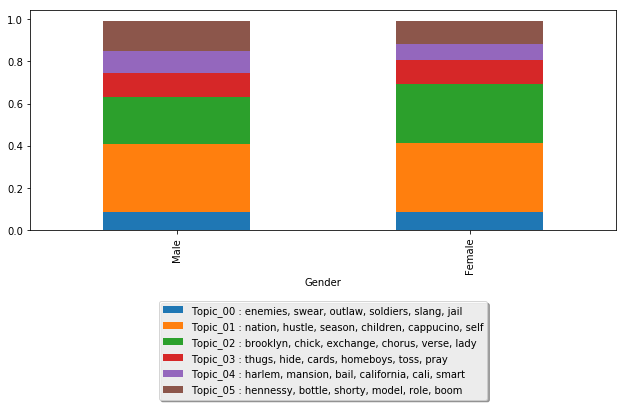

In [64]:
# And then topics by GENDER
visualize_average_topic_by_column(rap_df, 'Gender', lda, top_n_terms = 6)

# As as experiment, let's see what kinds of different topics and terms we might see if we train one model for each category and look at the result.
## In other words, instead of one model, we'll train one for East Coast and another for West Coast.  Then we'll do the same with one for Male and another for female

In [70]:
def get_text_indices(col_name, col_value, df, index_list):
    text_index_list = []
    for i, index in enumerate(index_list):
        if df.loc[index, col_name] == col_value:
            text_index_list.append(i)
            
    return text_index_list

In [77]:
east_tokenized_text_indices = get_text_indices('Coast', 'East', rap_df, index_list)
east_corpus = Corpus([filtered_tokenized_texts[idx] for idx in east_tokenized_text_indices])

west_tokenized_text_indices = get_text_indices('Coast', 'West', rap_df, index_list)
west_corpus = Corpus([filtered_tokenized_texts[idx] for idx in west_tokenized_text_indices])

male_tokenized_text_indices = get_text_indices('Gender', 'Male', rap_df, index_list)
male_corpus = Corpus([filtered_tokenized_texts[idx] for idx in male_tokenized_text_indices])

female_tokenized_text_indices = get_text_indices('Gender', 'Female', rap_df, index_list)
female_corpus = Corpus([filtered_tokenized_texts[idx] for idx in female_tokenized_text_indices])

print('Size of East Corpus : {}'.format(len(east_corpus)))
print('Size of West Corpus : {}'.format(len(west_corpus)))
print('Size of Male Corpus : {}'.format(len(male_corpus)))
print('Size of Female Corpus : {}'.format(len(female_corpus)))

Size of East Corpus : 1157
Size of West Corpus : 1028
Size of Male Corpus : 1903
Size of Female Corpus : 282


# Now let's train the models for each category.  This will take time for each model

In [98]:
# let's reduce how much time we'll need for each model by reducing the # of topics and passes across the data
NUM_STRATIFICATION_TOPICS = 5
NUM_STRATIFICATION_PASSES = 6

In [99]:
%%time

east_corpus.dictionary = corpus.dictionary

east_lda = gensim.models.ldamodel.LdaModel(east_corpus, 
                                     id2word = east_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 8.22 s


In [100]:
%%time

west_corpus.dictionary = corpus.dictionary

west_lda = gensim.models.ldamodel.LdaModel(west_corpus, 
                                     id2word = west_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 6.87 s


In [101]:
%%time

male_corpus.dictionary = corpus.dictionary

male_lda = gensim.models.ldamodel.LdaModel(male_corpus, 
                                     id2word = male_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 14.5 s


In [102]:
%%time

female_corpus.dictionary = corpus.dictionary

female_lda = gensim.models.ldamodel.LdaModel(female_corpus, 
                                     id2word = female_corpus.dictionary, 
                                     num_topics = NUM_STRATIFICATION_TOPICS,
                                         passes = NUM_STRATIFICATION_PASSES)

Wall time: 1.36 s


In [103]:
male_lda.print_topics(-1)

[(0,
  '0.005*"rise" + 0.005*"holla" + 0.005*"toss" + 0.005*"chorus" + 0.005*"hello" + 0.005*"funky" + 0.005*"ground" + 0.004*"stars" + 0.004*"lane" + 0.004*"road"'),
 (1,
  '0.006*"boom" + 0.004*"plug" + 0.003*"taste" + 0.003*"round" + 0.003*"thank" + 0.003*"swear" + 0.003*"cars" + 0.003*"park" + 0.003*"crip" + 0.003*"buck"'),
 (2,
  '0.007*"outlaw" + 0.006*"enemies" + 0.006*"rebel" + 0.006*"haters" + 0.006*"westside" + 0.005*"hustle" + 0.004*"power" + 0.004*"problems" + 0.004*"pimp" + 0.004*"outlawz"'),
 (3,
  '0.008*"self" + 0.008*"cali" + 0.007*"platinum" + 0.006*"cats" + 0.005*"california" + 0.004*"loot" + 0.004*"flipmode" + 0.004*"jones" + 0.004*"squad" + 0.004*"today"'),
 (4,
  '0.007*"water" + 0.006*"chick" + 0.006*"lady" + 0.006*"thugs" + 0.004*"woman" + 0.004*"dear" + 0.004*"count" + 0.004*"drama" + 0.003*"ways" + 0.003*"child"')]

In [104]:
female_lda.print_topics(-1)

[(0,
  '0.021*"minute" + 0.015*"chick" + 0.012*"alright" + 0.012*"leader" + 0.011*"brooklyn" + 0.007*"chorus" + 0.006*"bills" + 0.005*"butter" + 0.005*"taste" + 0.005*"chance"'),
 (1,
  '0.013*"posse" + 0.009*"princess" + 0.008*"ground" + 0.007*"holla" + 0.006*"battle" + 0.005*"brand" + 0.005*"wall" + 0.005*"smash" + 0.005*"badman" + 0.005*"lets"'),
 (2,
  '0.016*"clappers" + 0.014*"window" + 0.011*"kack" + 0.008*"supa" + 0.008*"rally" + 0.007*"stomp" + 0.007*"timbaland" + 0.006*"cappucino" + 0.006*"boom" + 0.005*"beats"'),
 (3,
  '0.024*"mommy" + 0.013*"dutch" + 0.010*"timbaland" + 0.008*"reverse" + 0.008*"weekend" + 0.007*"slide" + 0.007*"sock" + 0.006*"infinity" + 0.006*"junk" + 0.006*"anybody"'),
 (4,
  '0.009*"slap" + 0.006*"booty" + 0.005*"toot" + 0.005*"someone" + 0.005*"playa" + 0.005*"slim" + 0.005*"laugh" + 0.005*"funky" + 0.004*"haaa" + 0.004*"whatcha"')]